In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Подгрузка тренировочного датасета

In [ ]:
# !wget -O pokemon.zip
# !unzip pokemon.zip <link>
# !pip install wandb

Подгрузка обученной модели

In [ ]:
# Pre-trained model download
!wget -O DCGAN.pt <link>

--2022-10-19 17:51:19--  https://otecmicro.s-ul.eu/iCKS9El4
Resolving otecmicro.s-ul.eu (otecmicro.s-ul.eu)... 94.23.217.191
Connecting to otecmicro.s-ul.eu (otecmicro.s-ul.eu)|94.23.217.191|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185149375 (177M) [application/zip]
Saving to: ‘DCGAN.pt’

DCGAN.pt            100%[===================>] 176.57M  5.82MB/s    in 35s     

2022-10-19 17:51:55 (5.10 MB/s) - ‘DCGAN.pt’ saved [185149375/185149375]



In [ ]:
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

In [ ]:
def set_seed(seed):
    # torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

set_seed(3407)

In [ ]:
# import wandb
# wandb.login()

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATAROOT = "images"
WORKERS = 4
NUM_EPOCHS = 500
BATCH_SIZE = 128

Константы из статьи DCGAN, размер генерируемого изображения 64х64

In [ ]:
LR = 0.0002
BETA1 = 0.5
BETA2 = 0.999
IMAGE_SIZE = (64, 64)
LATENT_DIM = 100
FEATURES = 64

Демонстрация аугментации изображений

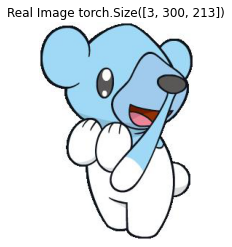

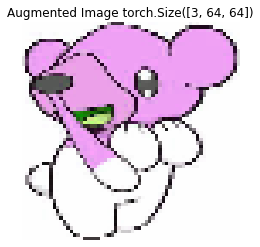

In [ ]:
dataset = ImageFolder(root=DATAROOT,transform=transforms.ToTensor())
dataloader = DataLoader(dataset,shuffle=True,batch_size = 1)
aug = transforms.Compose(
        [
            transforms.Resize(IMAGE_SIZE),
            transforms.ColorJitter(saturation=0.5, hue=0.5),
            transforms.RandomHorizontalFlip(p=0.5),])

image = next(iter(dataloader))[0][0]
plt.axis("off")
plt.title(f"Real Image {image.shape}")
plt.imshow(image.permute(1, 2, 0))
plt.show()

aug_image = aug(image)
plt.axis("off")
plt.title(f"Augmented Image {aug_image.shape}")
plt.imshow(aug_image.permute(1, 2, 0))
plt.show()

In [ ]:
dataset = ImageFolder(
    root=DATAROOT,
    transform=transforms.Compose(
        [
            transforms.Resize(IMAGE_SIZE),
            transforms.ColorJitter(saturation=0.5, hue=0.5),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)
dataloader = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS
)

Архитектура модели DCGAN: https://arxiv.org/abs/1511.06434

Были применены твики из https://github.com/soumith/ganhacks:

1. Лосс функция для G заместо min (log 1-D) --> max log D
2. Добавлены Gaussian noise в слои дискриминатора
3. Использован label smoothing при обучении дискриминатора
4. LeakyRelu в генераторе

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, features):
        super().__init__()
        self.net = nn.Sequential(
            *self.block(latent_dim, features * 16, 4, 1, 0),
            *self.block(features * 16, features * 8, 4, 2, 1),
            *self.block(features * 8, features * 4, 4, 2, 1),
            *self.block(features * 4, features * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                in_channels=features * 2,
                out_channels=3,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=True,
            ),
            nn.Tanh(),
        )

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class GaussianNoise(nn.Module):
    def __init__(self, std=0.1):
        super().__init__()
        self.std = std

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=features,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=True,
            ),
            nn.LeakyReLU(0.2, inplace=True),
            *self.block(features, features * 2, 4, 2, 1),
            *self.block(features * 2, features * 4, 4, 2, 1),
            *self.block(features * 4, features * 8, 4, 2, 1),
            nn.Conv2d(
                in_channels=features * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=True,
            ),
            nn.Sigmoid(),
        )

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            GaussianNoise(),
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class DCGAN:
    def __init__(
        self,
        num_epochs,
        lr,
        beta1,
        beta2,
        latent_dim,
        features,
        device,
    ):

        self.num_epochs = num_epochs
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.latent_dim = latent_dim
        self.features = features
        self.device = device

        self.G = Generator(self.latent_dim, self.features)
        self.D = Discriminator(self.features)

        self.G.to(self.device)
        self.D.to(self.device)

        self.initialize_weights(self.G)
        self.initialize_weights(self.D)

        self.loss = nn.BCELoss()

        self.d_optimizer = optim.Adam(
            self.D.parameters(), lr=self.lr, betas=(self.beta1, self.beta2)
        )
        self.g_optimizer = optim.Adam(
            self.G.parameters(), lr=self.lr, betas=(self.beta1, self.beta2)
        )

    def train(self, dataloader):
        # wandb.init(project="vk_try", name="DCGAN")

        self.G.train()
        self.D.train()


        for epoch in range(self.num_epochs):
            d_loss_list = []
            d_loss_real_list = []
            d_loss_fake_list = []
            g_loss_list = []
            for i, (real_images, _) in enumerate(dataloader):
                noise = torch.randn(
                    (real_images.size(0), self.latent_dim, 1, 1), device=self.device
                )
                real_images = real_images.to(self.device)
                g_output = self.G(noise)

                # Discriminator step max log(D(x)) + log(1 - D(G(z)))
                self.D.zero_grad()

                d_real_output = self.D(real_images).flatten()
                real_labels = torch.empty_like(d_real_output).uniform_(0.9, 1) # label smoothing
                d_loss_real = self.loss(d_real_output, real_labels)

                d_fake_output = self.D(g_output.detach()).flatten()
                fake_labels = torch.empty_like(d_fake_output).uniform_(0, 0.1) # label smoothing
                d_loss_fake = self.loss(d_fake_output, fake_labels)

                d_loss = (d_loss_real + d_loss_fake) / 2
                d_loss.backward()
                self.d_optimizer.step()

                # Generator step max log(D(G(z))
                self.G.zero_grad()

                d_fake_output = self.D(g_output).flatten()
                d_real_output = self.D(real_images).flatten()
                g_loss = self.loss(
                    torch.cat((d_fake_output, d_real_output)),
                    torch.cat(
                        (
                            torch.ones_like(d_fake_output, device=self.device),
                            torch.zeros_like(d_real_output, device=self.device),
                        ),
                    ),
                )

                g_loss.backward()
                self.g_optimizer.step()

                # Logging
                d_loss_list.append(d_loss.item())
                d_loss_real_list.append(d_loss_real.item())
                d_loss_fake_list.append(d_loss_fake.item())
                g_loss_list.append(g_loss.item())


            if epoch % 100 == 0:
                images_count = 32
                gen_images = self.generate(images_count)
                plt.figure(figsize=(15, 15))
                plt.axis("off")
                plt.title("Fake Images")
                plt.imshow(
                    make_grid(
                        gen_images[:images_count].cpu(), padding=2, normalize=True
                    ).permute(1, 2, 0)
                )
                plt.show()
                self.G.train()
                self.D.train()

            metrics = {
                "d_loss": sum(d_loss_list) / len(d_loss_list),
                "d_loss_real": sum(d_loss_real_list) / len(d_loss_real_list),
                "d_loss_fake": sum(d_loss_fake_list) / len(d_loss_fake_list),
                "g_loss": sum(g_loss_list) / len(g_loss_list),
            }
            print(f"Epoch: {epoch}: {metrics}")
            # wandb.log(metrics)

    def generate(self, images_count):
        self.D.eval()
        self.G.eval()
        with torch.no_grad():
            noise = torch.randn(images_count, 100, 1, 1, device=self.device)
            return self.G(noise).detach()

    def initialize_weights(self, model):
        for m in model.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            if isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def save(self, path):
        save_dict = {
            "discriminator": self.D.state_dict(),
            "generator": self.G.state_dict(),
            "d_optimizer": self.d_optimizer.state_dict(),
            "g_optimizer": self.g_optimizer.state_dict(),
        }
        torch.save(save_dict, path)

    def load(self, path):
        load_dict = torch.load(path)

        if "generator" in load_dict:
            print("Loaded gen")
            self.G.load_state_dict(load_dict["generator"])
        if "discriminator" in load_dict:
            print("Loaded dis")
            self.D.load_state_dict(load_dict["discriminator"])
        if "d_optimizer" in load_dict:
            print("Loaded d_opt")
            self.d_optimizer.load_state_dict(load_dict["d_optimizer"])
        if "g_optimizer" in load_dict:
            print("Loaded g_opt")
            self.g_optimizer.load_state_dict(load_dict["g_optimizer"])

In [ ]:
model = DCGAN(NUM_EPOCHS, LR, BETA1, BETA2, LATENT_DIM, FEATURES, DEVICE)
model.D

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): GaussianNoise()
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): GaussianNoise()
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): GaussianNoise()
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
   

In [ ]:
model.G

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvT

In [ ]:
# model.train(dataloader)

# model.save("/content/drive/MyDrive/colab/fulltrainedDCGAN.pt")

In [ ]:
model.load("DCGAN.pt")

Loaded gen
Loaded dis
Loaded d_opt
Loaded g_opt


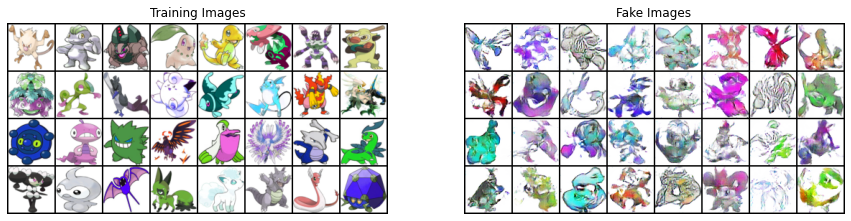

In [ ]:
images_count = 32
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    make_grid(
        next(iter(dataloader))[0][:images_count], padding=2, normalize=True
    ).permute(1, 2, 0)
)

gen_images = model.generate(images_count)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(make_grid(gen_images.cpu(), padding=2, normalize=True).permute(1, 2, 0))
plt.show()

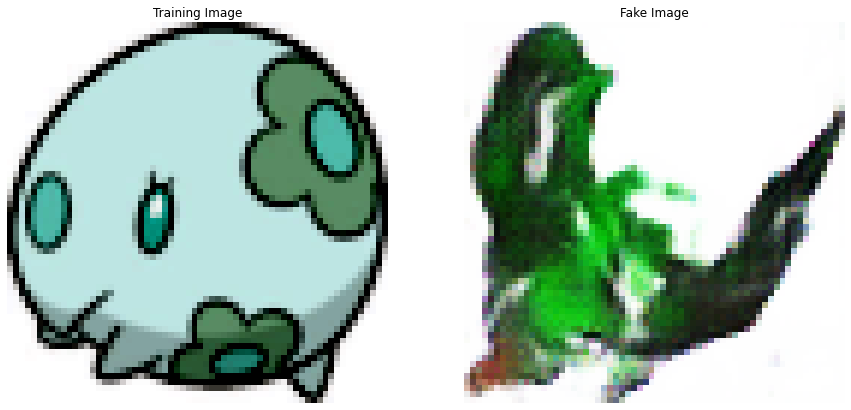

In [ ]:
images_count = 1
image = next(iter(dataloader))[0]
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Training Image")
plt.imshow(image[0].permute(1, 2, 0))

gen_images = model.generate(images_count)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Image")
plt.imshow(make_grid(gen_images.cpu(), padding=0, normalize=True).permute(1, 2, 0))
plt.show()